# Path Planning On a Grid :: Prioritized Multi-Agent Path Finding
<center><img src="./img/1.png"/></center>

In [237]:
import math
import os
import traceback
import warnings
from heapq import heappop, heappush
from random import randint, shuffle
from sys import float_info
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from IPython.display import Image as Img, display
from PIL import Image, ImageDraw, ImageOps, ImageFont
# from ipywidgets import IntProgress

# if you don't have joblib installed, please run `pip install` first; we will need this library only for testing purposes
# !pip install joblib
from joblib import Parallel, delayed

EPS = float_info.epsilon
%matplotlib inline

## Grid Map Representation

In [238]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [239]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '#' for obstacles and '.' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('#' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if char == "#" else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

## Dynamic Obstacles Domain

### Search Node

A Search node is a fundamental concept in heuristic search algorithms. It encapsulates data about the state of the problem (e.g., the position of a robot or agent on a grid) and the information needed to construct a search tree, including g-values, h-values, f-values, and a backpointer to its predecessor.

In [240]:
import time


class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node (also equals time moment when the agent reaches the cell).
    h : float | int
        h-value of the node (always 0 for Dijkstra).
    f : float | int
        f-value of the node (always equal to g-value for Dijkstra).
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
        time_step = 0
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node (also equals time moment when the agent reaches the cell).
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent
        self.time_step = time_step

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return self.i == other.i and self.j == other.j
    
    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j, self.time_step))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

### Implementing the Search Tree (i.e. OPEN,  CLOSED)

An efficient implementation of the search tree (OPEN and CLOSED) is crucial for any search algorithm. You should utilize the efficient search tree implementation you developed in the previous lab.

In [241]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_dublicates = 0  # Number of dublicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while not self.open_is_empty():
            current = heappop(self._open)
            if current not in self._closed:
                return current
            self._enc_open_dublicates += 1

        return None

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

### A* Algorithm with Timesteps

The first step in implementing prioritized planning for the `MAPF` problem is to adapt the `A*` search algorithm for a dynamic environment. This adaptation requires modifying the procedures used to generate new successors in the search tree (specifically, `compute_cost` and `get_neighbors`). For accurate successor generation, it's essential to detect conflicts with the trajectories of dynamic obstacles.

In this lab, we propose using a separate class, `CATable`, which contains several tables. These tables store information about the positions of dynamic objects at various time moments. Using this information, you will need to implement detection mechanisms for two types of collisions (conflicts):

- Vertex conflict: occurs when multiple agents occupy the same position at the same time.
- Edge conflict: happens when two agents move along the same edge concurrently, but in opposite directions.

It is important to note that an agent who has reached its goal position at time $t_1$ should not be considered in conflict with a dynamic obstacle passing through the same position at a different time $t_2$

In [242]:
def compute_cost_timesteps(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2) - `wait` action is allowed.

    Parameters
    ----------
        i1 : int
            Number of the first cell row in grid.
        j1 : int
            Number of the first cell column in grid.
        i2 : int
            Number of the second cell row in grid.
        j2 : int
            Number of the second cell column in grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """

    d = abs(i1 - i2) + abs(j1 - j2)
    if d == 0:  # wait
        return 1
    elif d == 1:  # cardinal move
        return 1
    else:
        raise ValueError(
            "Trying to compute the cost of a non-supported move! ONLY cardinal moves are supported."
        )

In [243]:
import time
from turtle import pos
from regex import F

from sympy import N, false


class CATable:
    """
    Implements a collision avoidance table for effectively checking
    collisions with dynamic obstacles.

    Attributes
    ----------
    _pos_time_table : Dict[Tuple[int, int, int], int]
        A table that checks if a cell (i, j) is occupied at time t.
        If the cell is occupied, the key (i, j, t) corresponds to a value
        equal to the ID of the trajectory passing through cell (i, j) at time t.

    _max_time_table : Dict[Tuple[int, int], int]
        This table stores information about the time t from which cell (i, j)
        will be permanently occupied. This is crucial to avoid collisions if
        the cell (i, j) is the final position of any trajectory. In such cases,
        starting from time t, it becomes impossible to pass through the cell.
        The key (i, j) corresponds to the time t equal to the duration of the
        trajectory that ends in this cell.

    _last_visit_table : Dict[Tuple[int, int], int | float]
        A table that stores information about the last moment when the cell (i, j)
        was occupied. This information is necessary to ensure that an agent remaining
        in its goal position (i, j) at time t1 does not collide with a dynamic obstacle
        at time t2 > t1.
    """

    def __init__(self):
        self._pos_time_table = dict()
        self._max_time_table = dict()
        self._last_visit_table = dict()

    def add_trajectory(self, traj_id: int, trajectory: List[Tuple[int, int]], add_last = True):
        """
        Adds a trajectory to the collision avoidance table. Each element of the trajectory
        represents the position at a specific time moment. For example, trajectory[0] is the
        position at time t = 0, trajectory[1] is at time t = 1, and so on.

        Parameters
        ----------
        traj_id : int
            Unique identifier for the trajectory.
        trajectory : List[Tuple[int, int]]
            The trajectory represented as a sequence of grid positions (i, j).
        """
        for time_step in range(len(trajectory)):
            i, j = trajectory[time_step]
            self._pos_time_table[(i, j, time_step)] = traj_id

            if (i, j) not in self._last_visit_table or self._last_visit_table[(i, j)] < time_step:
                self._last_visit_table[(i, j)] = time_step
        if add_last:
            final_i, final_j = trajectory[-1]
            self._max_time_table[(final_i, final_j)] = len(trajectory) - 1


    def check_move(self, i1: int, j1: int, i2: int, j2: int, t_start: int) -> bool:
        """
        Checks if the move from cell (i1, j1) to cell (i2, j2)
        between time moments t_start and t_start+1 will not result in
        a collision with other trajectories.

        Parameters
        ----------
        i1, j1 : int
            Coordinates of the starting cell on the grid map.
        i2, j2 : int
            Coordinates of the target cell on the grid map.
        t_start : int
            The time moment when the move begins.

        Returns
        -------
        bool
            True if the move is permissible without causing a collision, False otherwise.
        """
        if (i2, j2, t_start + 1) in self._pos_time_table or \
            (i2, j2) in self._max_time_table and self._max_time_table[(i2, j2)] <= t_start + 1 or \
            (i2, j2, t_start) in self._pos_time_table and (i1, j1, t_start + 1) in self._pos_time_table and \
            self._pos_time_table[(i2, j2, t_start)] == self._pos_time_table[(i1, j1, t_start + 1)]:
            return False
        
        return True

    def last_visited(self, i: int, j: int):
        """
        Returns the last time moment 't' when the cell (i, j) was occupied.
        If the cell has never been occupied, -1 is returned. If the cell becomes
        permanently occupied starting from a certain time moment, math.inf is returned.

        Parameters
        ----------
        i, j : int
            Coordinates of the cell on the grid map.

        Returns
        -------
        int | float
            The time 't' when the cell (i, j) was last occupied, -1 if never occupied,
            or math.inf if permanently occupied from a certain time moment.
        """
        if (i, j) in self._max_time_table:
            return math.inf
        if (i, j) in self._last_visit_table:
            return self._last_visit_table[(i, j)]
        return -1

    def __is_cell_available(self, i: int, j: int, t: int) -> bool:
        """
        Checks if a cell (i, j) is available at the specified time moment t.

        Parameters
        ----------
        i, j : int
            Coordinates of the cell on the grid map.
        t : int
            The time moment for which availability is checked.

        Returns
        -------
        bool
            True if the cell is not occupied at time t, False otherwise.
        """
        if (i, j) in self._max_time_table and self._max_time_table[(i, j)] <= t:
            return False
        if (i, j, t) in self._pos_time_table:
            return False
        return True

    def __is_reverse_move_valid(
        self, i1: int, j1: int, i2: int, j2: int, t_start: int, t_end: int
    ) -> bool:
        """
        Checks whether there is no concurrent move in the reverse direction along the same
        edge between the specified time moments t_start and t_end.

        Parameters
        ----------
        i1, j1 : int
            Coordinates of the starting cell for the move on the grid map.
        i2, j2 : int
            Coordinates of the target cell for the move on the grid map.
        t_start : int
            Time moment when the move starts.
        t_end : int
            Time moment when the move ends.

        Returns
        -------
        bool
            True if there is no reverse move along the same edge within the given time frame,
            False if there is a reverse move.
        """
        if  (i2, j2, t_start) in self._pos_time_table and (i1, j1, t_end) in self._pos_time_table and \
            self._pos_time_table[(i2, j2, t_start)] == self._pos_time_table[(i1, j1, t_end)]:
            return False
        
        return True
    
    def clear_pos_time_table(self):
        self._pos_time_table.clear()
    
    def clear_last_visit_table(self):
        self._last_visit_table.clear()



In [244]:
def get_neighbors_timestep(
    i: int, j: int, t: int, grid_map: Map, ca_table: CATable
) -> List[Tuple[int, int]]:
    """
    Returns a list of neighboring cells as (i, j) tuples. The function returns neighbors
    that allow only cardinal moves, as well as the current cell, to account for the possibility
    of a wait action.

    Parameters
    ----------
    i, j : int
        Coordinates of the cell on the grid map.
    grid_map : Map
        Static grid map information.
    ca_table : CATable
        Collision avoidance table.

    Returns
    -------
    neighbours : List[Tuple[int, int]]
        List of neighboring cell coordinates (i, j).
    """
    neighbors = grid_map.get_neighbors(i, j)
    neighbors.append((i, j))
    results = []

    for neigh_i, neigh_j in neighbors:
        if ca_table.check_move(i, j, neigh_i, neigh_j, t_start=t):
            results.append((neigh_i, neigh_j))
    
    return results

In [245]:
def manhattan_distance(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Calculates the Manhattan distance, which is the sum of the absolute differences
    of the coordinates, between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        Coordinates (i, j) of the first cell on the grid.
    i2, j2 : int
        Coordinates (i, j) of the second cell on the grid.

    Returns
    -------
    int | float
        The Manhattan distance between the two specified cells.
    """
    return abs(i1 - i2) + abs(j1 - j2)


The input of `A* with timesteps` algorithm includes:
- map representation
- collision avoidance table
- start and goal cells
- maximum allowed number of search steps
- heuristic function
- a reference to the implementation of the SearchTree

The output consists of:
- a flag indicating whether a path was found (`True` or `False`)
- the last node of the path, allowing one to backtrack using parent-pointers to retrieve the full path
- the number of steps (iterations of the main loop)
- the number of nodes that make up the search tree at the final iteration of the algorithm (equal to the size of the resultant search tree)
- OPEN and CLOSED as iterable collections of nodes

In [246]:
def astar_timesteps(
    task_map: Map,
    ca_table: CATable,
    start_node,
    goal_vertices: list[(int, int)],
    steps_max: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[
    bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]
]:
    """
    Implementation of A* algorithm without re-expansion on dynamic obstacles domain.
    """

    ast = search_tree()
    steps = 0
    start_node.h = heuristic_func(start_node.i, start_node.j, goal_vertices[0][0], goal_vertices[0][1])
    ast.add_to_open(start_node)

    current_goal_index = 0

    while not ast.open_is_empty():
        goal_i, goal_j = goal_vertices[current_goal_index][0], goal_vertices[current_goal_index][1]

        steps += 1
        if steps >= steps_max:
            return False, None, steps, len(ast), None, ast.expanded
        current_vertex = ast.get_best_node_from_open()
        if current_vertex is None:
            break
        
        ast.add_to_closed(current_vertex)
        if current_vertex.i == goal_i and current_vertex.j == goal_j and current_vertex.time_step > ca_table.last_visited(goal_i, goal_j):
            current_goal_index += 1
            if current_goal_index == len(goal_vertices):
                return True, current_vertex, steps, len(ast), ast.opened, ast.expanded
            ast._open.clear()
            ast.add_to_open(current_vertex)
            
        for s in get_neighbors_timestep(current_vertex.i, current_vertex.j, current_vertex.time_step, task_map, ca_table):
            if not ast.was_expanded(Node(i=s[0], j=s[1])):
                new_node = Node(s[0], s[1], 
                                g = current_vertex.g + compute_cost_timesteps(current_vertex.i, current_vertex.j, s[0], s[1]), 
                                h=heuristic_func(s[0], s[1], goal_i, goal_j), 
                                parent=current_vertex, 
                                time_step=current_vertex.time_step+1)
                ast.add_to_open(new_node)

    return False, None, steps, len(ast), None, ast.expanded


### Visualization

In [247]:
def draw_grid(draw_obj: ImageDraw, grid_map: Map, scale: Union[float, int]):
    """
    Draws static obstacles on the grid using draw_obj.

    Parameters
    ----------
    draw_obj : ImageDraw
        The drawing object to use.
    grid_map : Map
        The grid map containing obstacle information.
    scale : float or int
        The scaling factor for drawing.
    """
    height, width = grid_map.get_size()
    for row in range(height):
        for col in range(width):
            if not grid_map.traversable(row, col):
                top_left = (col * scale, row * scale)
                bottom_right = ((col + 1) * scale - 1, (row + 1) * scale - 1)
                draw_obj.rectangle(
                    [top_left, bottom_right], fill=(70, 80, 80), width=0.0
                )


def draw_start_goal(
    draw_obj: ImageDraw,
    start: Tuple[int, int],
    goals: list[Tuple[int, int]],
    scale: Union[float, int],
):
    """
    Draws start and goal cells on the grid using draw_obj.

    Parameters
    ----------
    draw_obj : ImageDraw
        The drawing object to use.
    start : Tuple[int, int]
        The start cell coordinates.
    goal : Tuple[int, int]
        The goal cell coordinates.
    scale : float or int
        The scaling factor for drawing.
    """

    def draw_cell(cell, fill_color, text = None):
        top_left = ((cell[1] + 0.1) * scale, (cell[0] + 0.1) * scale)
        bottom_right = ((cell[1] + 0.9) * scale - 1, (cell[0] + 0.9) * scale - 1)
        if text is not None:
            font = ImageFont.truetype("sans-serif.ttf", 16)
            draw_obj.draw.text((0, 0),"Sample Text",(255,255,255))
        draw_obj.rounded_rectangle(
            [top_left, bottom_right], fill=fill_color, width=0.0, radius=scale * 0.22
        )

    draw_cell(start, (40, 180, 99))  # Start cell color

    for goal in goals:
        draw_cell(goal, (231, 76, 60))  # Goal cell color


def draw_dyn_object(
    draw_obj: ImageDraw,
    path: List[Tuple[int, int]],
    step: int,
    frame_num: int,
    frames_per_step: int,
    scale: Union[float, int],
    color: Tuple[int, int, int],
    circle: bool,
):
    """
    Draws the position of a dynamic object at a specific time using draw_obj.

    Parameters
    ----------
    draw_obj : ImageDraw
        The drawing object to use.
    path : List[Tuple[int, int]]
        The path of the dynamic object.
    step : int
        The current step in the path.
    frame_num : int
        The current frame number.
    frames_per_step : int
        The number of frames per step.
    scale : float or int
        The scaling factor for drawing.
    color : Tuple[int, int, int]
        The fill color for the object.
    circle : bool
        Whether to draw the object as a circle.
    """
    path_len = len(path)
    curr_i, curr_j = path[min(path_len - 1, step)]
    next_i, next_j = path[min(path_len - 1, step + min(frame_num, 1))]

    di = frame_num * (next_i - curr_i) / frames_per_step
    dj = frame_num * (next_j - curr_j) / frames_per_step

    top_left = (float(curr_j + dj + 0.25) * scale, float(curr_i + di + 0.25) * scale)
    bottom_right = (
        float(curr_j + dj + 0.75) * scale - 1,
        float(curr_i + di + 0.75) * scale - 1,
    )
    if circle:
        draw_obj.ellipse([top_left, bottom_right], fill=color)
    else:
        draw_obj.rectangle([top_left, bottom_right], fill=color)

In [248]:
def create_frame(
    grid_map,
    scale,
    width,
    height,
    step,
    quality,
    starts,
    goals,
    paths,
    agent_colors,
    dyn_obst_traj,
    dyn_obst_color,
):
    frames = []
    for n in range(quality):
        im = Image.new("RGB", (width * scale, height * scale), color=(234, 237, 237))
        draw = ImageDraw.Draw(im)
        draw_grid(draw, grid_map, scale)

        if starts and goals:
            for start, goal in zip(starts, goals):
                draw_start_goal(draw, start, goal, scale)

        if paths:
            for path, agent_color in zip(paths, agent_colors):
                draw_dyn_object(
                    draw, path, step, n, quality, scale, agent_color, True
                )

        if dyn_obst_traj:
            for dyn_obst in dyn_obst_traj:
                draw_dyn_object(
                    draw,
                    dyn_obst,
                    step,
                    n,
                    quality,
                    scale,
                    dyn_obst_color,
                    False,
                )

        im = ImageOps.expand(im, border=2, fill="black")
        frames.append(im)
    return frames


def save_animation(images, output_filename, quality):
    images[0].save(
        f"{output_filename}.png",
        save_all=True,
        append_images=images[1:],
        optimize=False,
        duration=500 / quality,
        loop=0,
    )
    display(Img(filename=f"{output_filename}.png"))


def draw(
    grid_map: Map,
    starts: Optional[List[Tuple[int, int]]] = None,
    goals: Optional[List[Tuple[int, int]]] = None,
    paths: Optional[List[List[Tuple[int, int]]]] = None,
    dyn_obst_traj: Optional[List[List[Tuple[int, int]]]] = None,
    output_filename: str = "animated_trajectories",
):
    """
    Visualizes the environment, agent paths, and dynamic obstacles trajectories.

    Parameters
    ----------
    grid_map : Map
        Environment representation as a grid.
    starts : List[Tuple[int, int]] | None
        Starting positions of agents.
    goals : List[Tuple[int, int]] | None
        Goal positions of agents.
    paths : List[List[Tuple[int, int]]] | None
        Paths of agents between start and goal positions.
    dyn_obst_traj : List[List[Tuple[int, int]]] | None
        Trajectories of dynamic obstacles.
    output_filename : str
        Name of the file for the resulting animated visualization.
    """
    scale = 30
    quality = 6
    height, width = grid_map.get_size()

    dyn_obst_color = (70, 80, 80)

    agent_colors = [
        (randint(30, 230), randint(30, 230), randint(30, 230)) for _ in starts or []
    ]
    max_time = max((len(path) for path in paths), default=1) if paths else 1
    images = []

    for step in range(max_time):
        images.extend(
            create_frame(
                grid_map,
                scale,
                width,
                height,
                step,
                quality,
                starts,
                goals,
                paths,
                agent_colors,
                dyn_obst_traj,
                dyn_obst_color
            )
        )

    save_animation(images, output_filename, quality)

### Validating the Results¶

In [249]:
def make_path(goal: Node, start: Node = None,  h = 0) -> Tuple[List[Tuple[int, int]], Union[int, float]]:
    """
    Creates a path by tracing parent pointers from the goal node back to the start node.
    It also calculates the solution's duration.

    Parameters
    ----------
    goal : Node
        The goal node in the search tree from which to trace back.

    Returns
    -------
    Tuple[List[Tuple[int, int]], Union[int, float]]
        A tuple containing the path as a list of (i, j) coordinates, and the duration of the solution.
    """

    duration = goal.g
    current = goal
    path = []
    vertices = [] 
    if current == start:
        return [(current.i, current.j)], duration, current, True

    while current.parent and current != start:
        path.append((current.i, current.j))
        vertices.append(current)
        current = current.parent
    path.append((current.i, current.j))
    if h >= len(path): # если в данном промежутке времени размера h мы дошли до финальной вершины
        return path[::-1], duration, vertices[-1], True
    return path[::-1], duration, vertices[-h], False

In [250]:
def read_lists_from_file(path: str) -> List[List[Tuple[int, int]]]:
    """
    Reads data from a file and returns it in the form of a list of lists of tuples.

    Each line in the file should contain pairs of integers. Single integer lines
    signify the end of a current list of tuples.

    Parameters
    ----------
    path : str
        Path to the file to be read.

    Returns
    -------
    List[List[Tuple[int, int]]]
        A list of lists, where each sublist contains tuples of integers.
    """
    with open(path) as file:
        main_list = []
        curr_list = []
        for line in file:
            if not line.strip():
                continue
            nums = tuple(map(int, line.split()))

            if len(nums) == 1:
                if curr_list:
                    main_list.append(curr_list)
                    curr_list = []
            else:
                curr_list.append(nums)

        if curr_list:
            main_list.append(curr_list)

        return main_list

In [251]:
def check_start_goal(
    start: Tuple[int, int], goal: Tuple[int, int], trajectory: List[Tuple[int, int]]
) -> bool:
    """
    Checks whether the given trajectory begins at the start cell and ends at the goal cell.

    Parameters
    ----------
    start : Tuple[int, int]
        The starting cell coordinates.
    goal : Tuple[int, int]
        The goal cell coordinates.
    trajectory : List[Tuple[int, int]]
        The trajectory as a list of cell coordinates.

    Returns
    -------
    bool
        True if the trajectory starts at the start cell and ends at the goal cell, False otherwise.
    """
    return bool(trajectory) and trajectory[0] == start and trajectory[-1] == goal


def process_trajectory(
    traj_id: int,
    trajectory: List[Tuple[int, int]],
    pos_time: Dict,
    max_times: Dict,
    last_times: Dict,
):
    """
    Processes a single trajectory for collision checking by updating the given dictionaries
    with trajectory information.

    Parameters
    ----------
    traj_id : int
        The trajectory identifier.
    trajectory : List[Tuple[int, int]]
        The trajectory as a list of cell coordinates.
    pos_time : Dict
        Dictionary for storing positional time information.
    max_times : Dict
        Dictionary for storing maximum time information.
    last_times : Dict
        Dictionary for storing last time information.
    """
    for t, (i, j) in enumerate(trajectory):
        pos_time[(i, j, t)] = traj_id
        last_times[(i, j)] = max(last_times.get((i, j), -1), t)

    last_times[trajectory[-1]] = math.inf
    max_times[trajectory[-1]] = len(trajectory) - 1


def process_dyn_obstacles(
    dyn_obst_traj: List[List[Tuple[int, int]]]
) -> Tuple[Dict, Dict, Dict]:
    """
    Processes dynamic obstacles' trajectories for collision checking.

    Parameters
    ----------
    dyn_obst_traj : List[List[Tuple[int, int]]]
        List of dynamic obstacles' trajectories.

    Returns
    -------
    Tuple[Dict, Dict, Dict]
        Three dictionaries containing positional time, maximum time, and last time information.
    """
    pos_time, max_times, last_times = dict(), dict(), dict()

    for traj_id, trajectory in enumerate(dyn_obst_traj):
        process_trajectory(traj_id, trajectory, pos_time, max_times, last_times)

    return pos_time, max_times, last_times


def check_collisions(
    trajectory: List[Tuple[int, int]], pos_time: Dict, max_times: Dict, last_times: Dict
) -> bool:
    """
    Checks for collisions in the given trajectory with other trajectories.

    Parameters
    ----------
    trajectory : List[Tuple[int, int]]
        The trajectory to check for collisions.
    pos_time : Dict
        Dictionary containing positional time information of other trajectories.
    max_times : Dict
        Dictionary containing maximum time information.
    last_times : Dict
        Dictionary containing last time information.

    Returns
    -------
    bool
        True if no collisions are found, False otherwise.
    """
    for t1 in range(len(trajectory) - 1):
        i1, j1 = trajectory[t1]
        t2 = t1 + 1
        i2, j2 = trajectory[t2]

        if (i2, j2, t2) in pos_time or (
            (i2, j2) in max_times and max_times[(i2, j2)] <= t2
        ):
            return False
        if (
            (i1, j1, t2) in pos_time
            and (i2, j2, t1) in pos_time
            and pos_time[(i1, j1, t2)] == pos_time[(i2, j2, t1)]
        ):
            return False
    if len(trajectory) - 1 <= last_times.get(trajectory[-1], -1):
        return False
    return True

In [252]:
def check_path(
    start: Tuple[int, int],
    goal: Tuple[int, int],
    path: List[Tuple[int, int]],
    dyn_obst_traj: List[List[Tuple[int, int]]],
) -> bool:
    """
    Verifies whether the provided solution is correct and does not collide with the
    trajectories of dynamic obstacles.

    Parameters
    ----------
    start, goal : Tuple[int, int]
        The start and goal cells for the agent.
    path : List[Tuple[int, int]]
        The sequence of cells representing the path between the start and goal positions.
    dyn_obst_traj : List[List[Tuple[int, int]]]
        A list of sequences of cells, representing the trajectories of dynamic obstacles.

    Returns
    -------
    bool
        True if the path is correct and does not collide with dynamic obstacles, False otherwise.
    """

    return check_start_goal(start, goal, path) and check_collisions(
        path, *process_dyn_obstacles(dyn_obst_traj)
    )

When you finish implementing search algorithms, you'll naturally want to test them. The following functions will help you in doing just that.

`simple_test` runs the pathfinding algorithm on a single, straightforward instance, while massive_test executes it on a series of more involved instances. Both tests operate under the assumption that the search function follows the pattern below:

```
search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, search_tree_size, open, closed)
```


where
- `task_map` is the grid
- `ca_table` is the collision avoidance table
- `start.i, start.j` are the $(i, j)$ coordinates of the starting cell
- `goal.i, goal.j` are the  $(i, j)$ coordinates of the goal cell
- `*optional arguments*` represent additional parameters of the search function, passed with *args. For instance, the heuristic function.
- `path_found` is `True` if path was found and `False` otherwise
- `last_state` denotes the last state of the path. It returns `None` if a path was not found
- `steps` provides the number of search steps taken
- `search_tree_size` represents the number of nodes that make up the search tree at the final iteration of the algorithm, which equates to the size of the resultant search tree.
- `open` is an iterable collection of the nodes that form the search frontier (OPEN nodes)
- `closed` is an iterable collection of the expanded nodes (CLOSED)

In [253]:

from regex import P


def get_paths(starts: list[(int, int)], goals: list[list[(int, int)]], ca_table: CATable, map: Map, h: int, w: int):
    all_good = 1
    paths = [ [] for _ in range(len(goals)) ]
    path_founds = len(goals) * [False]
    reached_goals = [0] * len(goals)
    count_paths = 0
    iter_count = 0
    next_iter_start_vertices = [None] * len(goals)
    while True:

        if count_paths == len(goals):
            break

        ca_table.clear_last_visit_table()
        ca_table.clear_pos_time_table()

        for i in range(len(goals)):
            if not path_founds[i]:
                start_node = next_iter_start_vertices[i]
                if start_node is None:
                    start_node = Node(starts[i][0], starts[i][1])

                start_node.time_step = 0

                reached, last_vertex, _, _, _, _ = astar_timesteps(map, ca_table, 
                                                                start_node, 
                                                                goals[i][reached_goals[i]:], 10000,
                                                                manhattan_distance, SearchTreePQD)
                
                if not reached: 
                    print('path not found')
                    all_good = 0
                else:
                    path, _, last_h_vertex, find_path = make_path(last_vertex, start_node, h)
                    if find_path:
                        path_founds[i] = True
                        count_paths += 1
                        for vertex in path[:h]:
                            paths[i].append(vertex)
                        ca_table.add_trajectory(i, path)
                        continue
                    
                    next_iter_start_vertices[i] = last_h_vertex
                    
                    for vertex in path[:h]:
                        if vertex == goals[i][reached_goals[i]]:
                            reached_goals[i] += 1
                        paths[i].append(vertex)


                    ca_table.add_trajectory(i, path[:w], False)
                    
        iter_count += 1
    return paths, all_good

In [254]:
(1,2 )==(1,2)

True

In [255]:
def simple_test(search_function: Callable, task: Union[int, None], *args):
    """
    Function `simple_test` runs `search_function` on one task. Use a number from 0 to 24 to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered.
     - 'Execution error' if an error occurred during the execution of the search_function.
    In the first case, the function also provides a visualization of the task.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 24 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """

    def get_map_data():
        map_str = dedent(
            """
            . . . # # . . . . . . . . # # . . . # . . # # . . . . . . .  
            . . . # # # # # . . # . . # # . . . . . . # # . . . . . . . 
            . . . . . . . # . . # . . # # . . . # . . # # . . . . . . . 
            . . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
            . . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
            . . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
            . . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
            . . . . . . . # . . # . . # # . . . # . . # . . . . . . . . 
            . . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
            . . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
            . . . # # . . . . . # . . . . . . . # . . . . . . . . . . . 
            . . . # # # # # # # # # # # # # . # # . # # # # # # # . # # 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . .
        """
        )
        cells = convert_string_to_cells(map_str)
        return Map(cells)

    task_map = get_map_data()
    starts = [(1, 28), (2, 29), (3, 20), (2, 20), (0, 0)]
    # goals = [[(0, 1), (2, 0)], [(6, 2)], [(5, 6)], [(13, 0)], [(4, 23)]]
    goals = [[(0, 1), (3,0 )], [(6, 2), (3, 2)], [(5, 6), (8, 6)], [(13, 0), (14, 10)], [(4, 23)]]

    # starts = [(1, 28)]
    # goals = [[(0,0) , (1,1)]]
    ca_table = CATable()
    paths, all_good = get_paths(starts, goals, ca_table, task_map, 5, 1000)


    draw(task_map, starts, goals, paths)


### Experimental evaluation

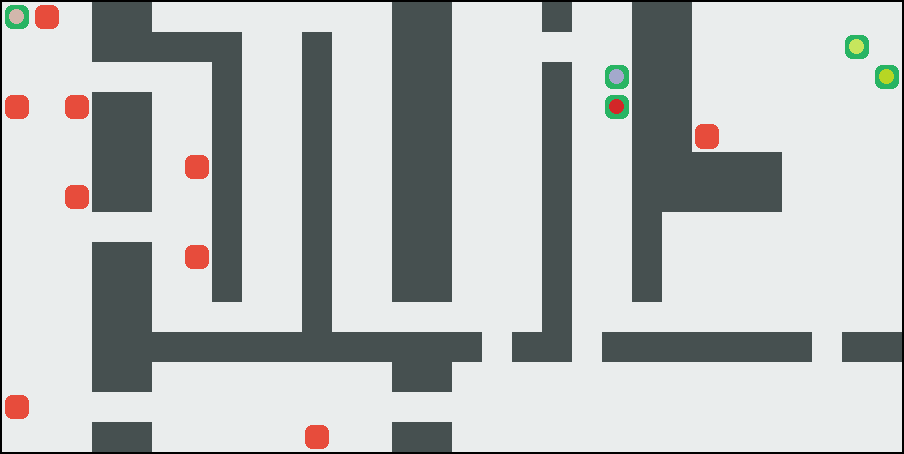

CPU times: total: 4.03 s
Wall time: 4.16 s


In [256]:
%time simple_test(astar_timesteps, 0, 10000, manhattan_distance, SearchTreePQD)